# VHDL implementation of Steppermotordriver for L6208PD

In [8]:
# Function to calculate the Bits needed fo a given number
def unsigned_num_bits(num):
  _nbits = 1
  _n = num
  while(_n > 1):
    _nbits = _nbits + 1
    _n     = _n / 2
  return _nbits

## Steppermotor ST4118S0206-A settings
Speed = $120\frac{1}{min}$

1 Revolution = $0.5mm$

1 Step = $1.8°$

### Distance calulcation

In [9]:
rev_distance = 0.5 # mm
step_angle   = 1.8 # °

# Calculation one Step
step_distance = rev_distance/360*step_angle
print("Step Distance               = {} mm".format(step_distance))
print("Step Distance               = {} um".format(step_distance*1000))

# Calculation max and min register position
RegBitNb = 32
regval_max =  2**(RegBitNb-1)-1
regval_min = -2**(RegBitNb-1)

step_distance_max = regval_max*step_distance
step_distance_min = regval_min*step_distance

print("Register Position Values    = {} ... {}".format(regval_max, regval_min))
print("Position Register distances = {} m ... {} m".format(step_distance_max/1000, step_distance_min/1000))

Step Distance               = 0.0025 mm
Step Distance               = 2.5 um
Register Position Values    = 2147483647 ... -2147483648
Position Register distances = 5368.7091175 m ... -5368.70912 m


### Max Frequency calulation
$f_{max} = speed * steps = \frac{1}{s}*1 = \frac{1}{s} $

In [10]:
speed_max =  60# rev/min
step_angle = 1.8 # °

steps_per_rev = 360/step_angle
speed_max_sec = speed_max/60 # rev/sec

f_max = speed_max_sec * steps_per_rev
print("Max Frequency of Steppermotor is {} Hz".format(f_max))


Max Frequency of Steppermotor is 200.0 Hz


### Max Speed calculations
$g\_MAX\_SPEED = \frac{(speed_{resolution}-1)*clk_{freq}}{speed_{max}*steps\_per\_rev} = \frac{([values]-1)*[Hz]}{[\frac{rev}{s}]*[\frac{steps}{rev}]}$

In [11]:
speed_resolution     = 2**8   # different speed values
clk_freq             = 100e6  # Hz
speed_max            = 120*1/60 # rev/min * min/s = rev/s
steps_per_rev        = 200    # steps per revolution

g_max_speed = ((speed_resolution-1)*clk_freq)/(speed_max*steps_per_rev)
print("g_MAX_SPEED = {} needs {} Bits".format(int(g_max_speed), unsigned_num_bits(int(g_max_speed))))

g_MAX_SPEED = 63750000 needs 27 Bits


### Max Acceleration calculations
$g\_MAX\_ACCELERATION = \frac{speed_{max}*clk_{freq}}{(speed_{resolution}-1)*acceleration\_speed} = \frac{[\frac{rev}{s}]*[Hz]}{([values]-1)*[\frac{rev}{s^{2}}]}$

$g\_MAX\_DECCELERATION = \frac{speed_{max}*clk_{freq}}{(speed_{resolution}-1)*decceleration\_speed} = \frac{[\frac{rev}{s}]*[Hz]}{([values]-1)*[\frac{rev}{s^{2}}]}$

In [12]:
speed_resolution     = 2**8   # different speed values
clk_freq             = 100e6  # Hz
speed_max            = 60*1/60 # rev/min * min/s = rev/s

max_acceleration_time = 2.0 # seconds from 0 to max speed
max_acceleration_rev  = speed_max/max_acceleration_time # rev/s^2

max_decceleration_time = 1.0 # seconds from max to 0 speed
max_decceleration_rev  = speed_max/max_decceleration_time # rev/s^2

g_max_acceleration  = (speed_max*clk_freq)/((speed_resolution-1)*max_acceleration_rev)
g_max_decceleration = (speed_max*clk_freq)/((speed_resolution-1)*max_decceleration_rev)

print("g_MAX_ACCELERATION  = {} needs {} Bits".format(int(g_max_acceleration),unsigned_num_bits(int(g_max_acceleration))))
print("g_MAX_DECCELERATION = {} needs {} Bits".format(int(g_max_decceleration),unsigned_num_bits(int(g_max_decceleration))))

g_MAX_ACCELERATION  = 784313 needs 21 Bits
g_MAX_DECCELERATION = 392156 needs 20 Bits


### Speed intended calculations
$ speed_{indended} = \sqrt[2]{2*64*g\_MAX\_ACCELERATION*|position_{difference}|} $
or
$ speed_{indended} = 41*\log({g\_MAX\_ACCELERATION*|position_{difference}|}) $

speed_intended:   0 @ position_difference:     0
speed_intended:  28 @ position_difference:     1
speed_intended:  45 @ position_difference:     2
speed_intended:  66 @ position_difference:     4
speed_intended:  90 @ position_difference:     8
speed_intended: 116 @ position_difference:    16
speed_intended: 143 @ position_difference:    32
speed_intended: 171 @ position_difference:    64
speed_intended: 199 @ position_difference:   128
speed_intended: 228 @ position_difference:   256
speed_intended: 255 @ position_difference:   512
speed_intended: 255 @ position_difference:  1024
speed_intended: 255 @ position_difference:  2048
speed_intended: 255 @ position_difference:  4096
speed_intended: 255 @ position_difference:  8192
speed_intended: 255 @ position_difference: 16384
speed_intended: 255 @ position_difference: 32768
speed_intended: 255 @ position_difference: 65536


Text(0.5,1,'Acceleration & Deccleration')

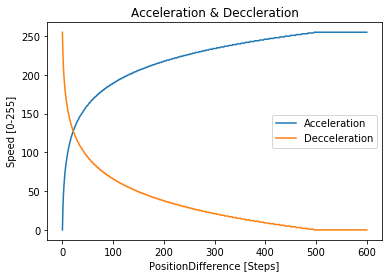

In [13]:
import math
speed_resolution      = 2**8 # different speed values
speed_max             = 120*1/60 # rev/min * min/s = rev/s
max_acceleration_time = 2.0 # seconds from 0 to max speed
max_acceleration_rev  = speed_max/max_acceleration_time # rev/s^2

def calc_speed_intended(max_acceleration_rev, position_difference):
#  return round(math.sqrt(2*64*max_acceleration_rev*position_difference))
  return round(41*math.log(max_acceleration_rev*position_difference+1))

for position_difference in [0,1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536]:
  speed_intended = calc_speed_intended(max_acceleration_rev, position_difference)
  if speed_intended > speed_resolution-1:
    speed_intended = speed_resolution-1
  print("speed_intended: {:3} @ position_difference: {:5}".format(int(speed_intended),position_difference))

# Draw Plot
import numpy as np
import pylab as pl
pl.clf()

nbrOfPoints = 600
position_difference = np.linspace(0,nbrOfPoints,nbrOfPoints)

speed_intended = np.empty(shape=[len(position_difference)], dtype=np.float64)
for i in range(len(position_difference)):
  speed_intended[i] = calc_speed_intended(max_acceleration_rev, position_difference[i])
  if speed_intended[i] > speed_resolution-1:
    speed_intended[i] = speed_resolution-1
# Plot graph
pl.plot(position_difference,speed_intended, label="Acceleration")

speed_intended = np.empty(shape=[len(position_difference)], dtype=np.float64)
for i in range(len(position_difference)):
  speed_intended[i] = 255-calc_speed_intended(max_acceleration_rev, position_difference[i])
  if speed_intended[i] <= 0:
    speed_intended[i] = 0
# Plot graph
pl.plot(position_difference,speed_intended, label="Decceleration")

# Place legend, Axis and Title
pl.legend(loc='best')
pl.xlabel("PositionDifference [Steps]")
pl.ylabel("Speed [0-255]")
pl.title("Acceleration & Deccleration")


### Max Step Frequency

$g\_STEP\_FREQ = \frac{f_{clk}}{f\_step\_driver_{max}}$

For $f\_step\_driver_{max}$ see datasheet motor driver (L6208 = $100kHz$)

In [14]:
f_clk      = 100e6 # Hz
f_step_max = 100e3 # Hz

g_step_freq = f_clk/f_step_max
print("Number of steps for max step frequency: {} needs {} Bits".format(int(g_step_freq), unsigned_num_bits(g_step_freq)))

Number of steps for max step frequency: 1000 needs 11 Bits
